In [1]:
import scipy
import numpy as np
from sympy.utilities.iterables import multiset_partitions, partitions
from itertools import permutations
# plot the bn values
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax.numpy as jnp
import jax
import math
from tqdm import tqdm

# Computing the norm of $\|\Psi^{[2s]}_{m,p}\|$

In [2]:
factorial = {}
for i in range(100):
    factorial[i] = np.longdouble(math.factorial(i))

We define the parameters we are interested in:

In [3]:
cs = {} # It will be indexed by (s, m)
cs[(2,2)] = [[1/2, 1/6], [1/2, 1/6]]
cs[(2,3)] = [[0, 1/12], [1, 0], [0, 1/12]]
cs[(3,5)] = [[0.2, 0.08734395950888931101, 0.03734395950888931101], 
        [0.34815492558797391479, 0.053438272547684150, 0.00584269157837031012],
        [abs(1-2*(0.2+0.34815492558797391479)), 0, abs(1/12-2*(0.03734395950888931101 + 0.00584269157837031012))],
        [0.34815492558797391479, 0.053438272547684150, 0.00584269157837031012],
        [0.2, 0.08734395950888931101, 0.03734395950888931101]]
cs[(3,6)] = [[0.208, 0.09023186422416794596, 0.03823186422416794596], 
        [0.312, 0.04467385661651479788, 0.00439421553992544024],
        [abs(1/2-(0.208 + 0.09023186422416794596)), 0.01407960659498524468, abs(1/24-(0.03823186422416794596+0.00439421553992544024))],
        [abs(1/2-(0.208 + 0.09023186422416794596)), 0.01407960659498524468, abs(1/24-(0.03823186422416794596+0.00439421553992544024))],
        [0.312, 0.04467385661651479788, 0.00439421553992544024],
        [0.208, 0.09023186422416794596, 0.03823186422416794596]]
cs[(4,11)] = [
        [0.169715531043933180094151, 0.152866146944615909929839, 0.119167378745981369601216, 0.068619226448029559107538],
        [0.379420807516005431504230, 0.148839980923180990943008, 0.115880829186628075021088, 0.188555246668412628269760],
        [0.469459306644050573017994, 0.379844237839363505173921, 0.022898814729462898505141, 0.571855043580130805495594],
        [0.448225927391070886302766, 0.362889857410989942809900, 0.022565582830528472333301, 0.544507517141613383517695],
        [0.293924473106317605373923, 0.026255628265819381983204, 0.096761509131620390100068, 0.000018330145571671744069],
        [0.447109510586798614120629, 0, 0.200762581179816221704073, 0],
        [0.293924473106317605373923, 0.026255628265819381983204, 0.096761509131620390100068, 0.000018330145571671744069],
        [0.448225927391070886302766, 0.362889857410989942809900, 0.022565582830528472333301, 0.544507517141613383517695],
        [0.469459306644050573017994, 0.379844237839363505173921, 0.022898814729462898505141, 0.571855043580130805495594],
        [0.379420807516005431504230, 0.148839980923180990943008, 0.115880829186628075021088, 0.188555246668412628269760],
        [0.169715531043933180094151, 0.152866146944615909929839, 0.119167378745981369601216, 0.068619226448029559107538]
        ]

In [17]:
s = 4
maxp = 30
m = 11
h = 1/(4*m) #1/(4*m)

We need two key functions `efficient_number_compositions` and `efficient_weak_compositions`

In [5]:
def efficient_number_compositions(p, s):
    r"""
    p: integers up to which compositions add up
    s: maximum value of each term in the composition

    Computes a dictionary where the key is the length of the composition,
    and the value is the number of compositions of that length.
    """
    pts = partitions(p, k=s)
    
    comps = {}
    for part in pts:
        len_ = np.sum(list(part.values()))

        num_comps = factorial[len_]
        for n in part.values():
            num_comps /= factorial[n]

        if len_ in comps.keys():
            comps[len_] += num_comps
        else:
            comps[len_] = num_comps

    return comps

In [6]:
def partition_to_list(part):
    l = []
    for k, v in part.items():
        l += [k]*v
    return l


def add_term(m, mean_cs, part):
    part_ = partition_to_list(part)
    part_ = part_ + [0]*(m-len(part_))
    perms = permutations(part_)
                
    add_term = np.longdouble(0)
    for per in perms:
        add_term += np.prod([mean_cs[i]**per[i]/factorial[per[i]] for i in range(len(per))])
    return add_term

def efficient_weak_compositions(maxw, list_m, list_cs, use_max = True):
    r"""
    Computes sum{k_1...k_m\in weak_compositions} c^{k_1}/k_1!...c^{k_m}/k_m!) for all weak compositions of length m.
    Depending on the value of `use_max`, it uses either the maximum value of c for all at once (faster) or the specific values of c,
    (more accurate).

    maxw: maximum value of the sum of the weak composition
    list_m: list of the possible values of m.
    list_cs: list of the possible values of cs.
    use_max: if True, use the maximum value of cs instead of the specific values of cs. Faster but less accurate.
    """

    weak_comps = {}
    for m, cs in zip(list_m, list_cs):

        vector_add_term = np.vectorize(lambda part: add_term(m, mean_cs, part))

        max_cs = np.max(cs)
        mean_cs = np.mean(cs, axis = 1)

        weak_comps[m] = {}
        for normw in range(maxw+1):
            
            suma = np.longdouble(0)

            pts = partitions(normw, m=m)

            if use_max:
                for part in pts:
                    len_ = np.sum(list(part.values()))

                    num_comps = factorial[m]/factorial[m-len_] * max_cs**len_
                    for n in part.values():
                        num_comps /= factorial[n]

                    denominator = np.longdouble(1)
                    for i in part.keys():
                        denominator = denominator*factorial[i]

                    suma = suma + num_comps/denominator

            else:
                add = vector_add_term(list(pts))
                suma += np.sum(add)

            weak_comps[m][normw] = suma

    return weak_comps


maxw = 20
weak_comps = efficient_weak_compositions(maxw, list_m = [m], list_cs = [cs[(s,m)]], use_max=False)
for normw in range(maxw+1):
    print(f'm={m}, w={normw}, result={weak_comps[m][normw]}')

m=6, w=0, result=720.0
m=6, w=1, result=73.14711648584196
m=6, w=2, result=11.242167771290237
m=6, w=3, result=1.2640311468138534
m=6, w=4, result=0.14928528672831104
m=6, w=5, result=0.015443591264099124
m=6, w=6, result=0.0016469290671441046
m=6, w=7, result=9.720275231769182e-05
m=6, w=8, result=6.704968142211123e-06
m=6, w=9, result=3.7910828615795877e-07
m=6, w=10, result=2.2072913098487436e-08
m=6, w=11, result=1.0731278791184764e-09
m=6, w=12, result=5.5680185646304536e-11
m=6, w=13, result=2.177074819955771e-12
m=6, w=14, result=9.173694447291485e-14
m=6, w=15, result=3.4025395370427856e-15
m=6, w=16, result=1.2602620426565485e-16
m=6, w=17, result=4.138755674323608e-18
m=6, w=18, result=1.4172907380280127e-19
m=6, w=19, result=4.074224450288789e-21
m=6, w=20, result=1.2234001899344244e-22


Final calculation

In [18]:
def summatory_compositions(h, maxp, s, list_m, list_cs, use_max = True): #todo: better choose between maximum and actual value
    r"""
    maxp: maximum order p of the summatory
    s: 2s is the order of the Commutator Free Magnus operator
    maxc: maximum value of the norm of |x_{i,j}a_j|
    cs: list of values |x_{i,j}a_j| for each i,j

    Note: you should choose one of cs and maxc, not both.
    """

    weak_comps = efficient_weak_compositions(maxp, list_m, list_cs, use_max)

    suma = {}
    for p in range(1, maxp+1):
        num_comps = efficient_number_compositions(p, s)

        suma[p] = np.longdouble(0)
        for len_comp, nc in num_comps.items():
            suma[p] += nc*weak_comps[m][len_comp] * h**p

    return suma

sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max = True)

#accumulate sum_compositions
acc_sum_compositions = {}
acc_sum_compositions[0] = 0
for i in range(1, maxp+1):
    acc_sum_compositions[i] = acc_sum_compositions[i-1] + sum_compositions[i]


for i in range(1, maxp+1):
    print(f'{i}: {sum_compositions[i]}, {acc_sum_compositions[i]}')

1: 0.1429637608950327, 0.1429637608950327
2: 0.014164054089263429, 0.15712781498429615
3: 0.0011556556238333945, 0.15828347060812956
4: 8.435772410650184e-05, 0.15836782833223606
5: 5.677212785506399e-06, 0.15837350554502155
6: 3.598227851577919e-07, 0.1583738653678067
7: 2.1747491100688776e-08, 0.15837388711529782
8: 1.2628148401893954e-09, 0.15837388837811267
9: 7.079474425604358e-11, 0.1583738884489074
10: 3.845897194442861e-12, 0.1583738884527533
11: 2.0306139868222358e-13, 0.15837388845295636
12: 1.0448482203803446e-14, 0.1583738884529668
13: 5.252558380937393e-16, 0.15837388845296732
14: 2.5859831785770568e-17, 0.15837388845296735
15: 1.249682730412879e-18, 0.15837388845296735
16: 5.940132507618809e-20, 0.15837388845296735
17: 2.7824138604710817e-21, 0.15837388845296735
18: 1.2863960151670137e-22, 0.15837388845296735
19: 5.8781062761132444e-24, 0.15837388845296735
20: 2.6575187408189323e-25, 0.15837388845296735
21: 1.1897294193446987e-26, 0.15837388845296735
22: 5.277318393019912

Accumulating the error over all orders $p>2s+1$

In [19]:
def acc_from(i, sum_compositions, maxp):
    
    acc_sum_compositions = {}
    acc_sum_compositions[i-1] = 0
    for i in range(i, maxp+1):
        acc_sum_compositions[i] = acc_sum_compositions[i-1] + sum_compositions[i]

    return acc_sum_compositions

acc_sum_compositions = acc_from(2*s+1, sum_compositions, maxp)
for i in range(2*s+1, maxp+1):
    print(f'{i}: {acc_sum_compositions[i]}')

9: 7.079474425604358e-11
10: 7.464064145048644e-11
11: 7.484370284916866e-11
12: 7.485415133137247e-11
13: 7.485467658721057e-11
14: 7.485470244704236e-11
15: 7.485470369672509e-11
16: 7.485470375612642e-11
17: 7.485470375890883e-11
18: 7.485470375903747e-11
19: 7.485470375904335e-11
20: 7.485470375904363e-11
21: 7.485470375904364e-11
22: 7.485470375904364e-11
23: 7.485470375904364e-11
24: 7.485470375904364e-11
25: 7.485470375904364e-11
26: 7.485470375904364e-11
27: 7.485470375904364e-11
28: 7.485470375904364e-11
29: 7.485470375904364e-11
30: 7.485470375904364e-11


We can compare using both modes in, for $s = 3$ and $m = 5$ and $m = 6:

In [10]:
sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max = True)

acc_sum_compositions = acc_from(2*s+1, sum_compositions, maxp)
for i in range(2*s+1, maxp+1):
    print(f'{i}: {acc_sum_compositions[i]}')

7: 1.9826761441780353e-08
8: 2.1195662281119414e-08
9: 2.1287833070435784e-08
10: 2.129391745212139e-08
11: 2.1294312404704615e-08
12: 2.1294337682074482e-08
13: 2.1294339281894766e-08
14: 2.1294339382273752e-08
15: 2.129433938852205e-08
16: 2.1294339388907903e-08
17: 2.129433938893154e-08
18: 2.1294339388932976e-08
19: 2.1294339388933062e-08
20: 2.129433938893307e-08


In [11]:
sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max = False)

acc_sum_compositions = acc_from(2*s+1, sum_compositions, maxp)
for i in range(2*s+1, maxp+1):
    print(f'{i}: {acc_sum_compositions[i]}')

7: 2.2270680814019967e-09
8: 2.2918155165031245e-09
9: 2.293493412952103e-09
10: 2.293531840383346e-09
11: 2.293532836672026e-09
12: 2.293532860563087e-09
13: 2.293532861107771e-09
14: 2.2935328611205704e-09
15: 2.2935328611208475e-09
16: 2.2935328611208533e-09
17: 2.2935328611208533e-09
18: 2.2935328611208533e-09
19: 2.2935328611208533e-09
20: 2.2935328611208533e-09


Let us plot the different errors for every formula and every $m$, for different values of $h$.

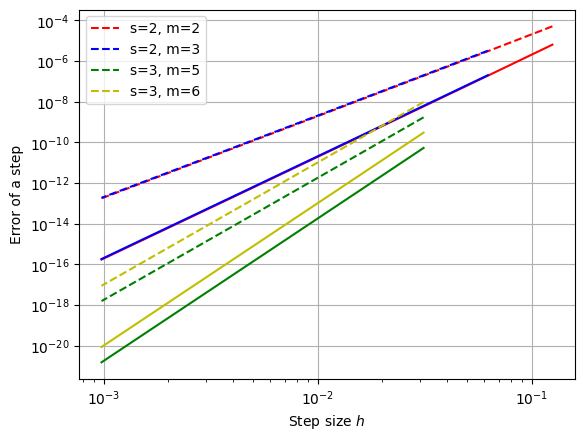

<Figure size 640x480 with 0 Axes>

In [54]:
hs = [1/(2) * 1/2**i for i in range(1,10)]
maxp = 20
tight = True
for (s, m, color) in zip([2, 2, 3, 3], [2, 3, 5, 6], ['r', 'b', 'g', 'y']):
    plot_hs = []
    step_error = []
    error = []
    for h in hs:
        if h <= 1/(4*m):
            plot_hs.append(h)
        else:
            continue
        if s < 4:
            sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max= not tight)
        else:
            sum_compositions = summatory_compositions(h, maxp, s, [m], [cs[(s,m)]], use_max=True)

        acc_sum_compositions = acc_from(2*s+1, sum_compositions, maxp)
        error.append(acc_sum_compositions[maxp])
        step_error.append(acc_sum_compositions[maxp]/h)

    plt.plot(plot_hs, error, color = color, label = f's={s}, m={m}')
    # Discontinous plot for the step error
    plt.plot(plot_hs, step_error, color = color, linestyle='dashed', label = f's={s}, m={m}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error of a step')
plt.xlabel(r'Step size $h$')
plt.grid()
plt.show()
plt.savefig(f'error_bounds_tight={tight}.pdf')


# Error bound for $\|\exp(\Omega_{2s,2s})_{p}\|$

In [80]:
# Compute all the permutations of a partition
def partition_to_list(part):
    l = []
    for k, v in part.items():
        l += [k]*v
    return l

In [105]:
def efficient_bound(h, p, s, maxc):
    r"""
    Computes a bound for the error of the Magnus expansion of order p.

    p: order of the Magnus expansion
    s: 2s is the order of the Commutator Free Magnus operator
    z: order of the exponential of the Magnus expansion.
    c: maximum value of the norm of |a_j|
    """
    bound = np.longdouble(0)

    # We first generate all partitions of p into z parts of size up to 2s
    pts = list(partitions(p))

    # For each possible partition,
    for part in pts:
        large_comb_size = np.sum(list(part.values()))
        num_combs_large = factorial[large_comb_size]/np.prod([factorial[v] for v in part.values()])


        # We further generate more partitions of each part into up to 2s parts
        product = np.longdouble(1)
        for k in part.keys(): # Iterating over the dictionary of a big partition
            suma = np.longdouble(0)
            js = partitions(k)
            for j in js: # Here we get a dictionary of small partitions
                size = np.sum(list(j.values()))
                num_small_combs = factorial[size]/np.prod([factorial[jv] for jv in j.values()])
                #print('j:', j, 'size:', size, 'num_small_combs:', num_small_combs)
                term = maxc**size / size 
                term = term / np.prod([jk**jv for jk, jv in j.items()])
                suma = suma + term * num_small_combs

            #print('sum', suma/2**(k-1))

            product = product * suma

        bound += num_combs_large/factorial[large_comb_size] * product

    return bound * (h/2)**p

h = 1/10
s = 2
maxc = 1
for p in range(1, 30):
    print(p, efficient_bound(h, p, s, maxc))

1 0.05
2 0.0037500000000000007
3 0.0002916666666666667
4 2.291666666666667e-05
5 1.8072916666666673e-06
6 1.412326388888889e-07
7 1.1207527281746036e-08
8 8.734314933655759e-10
9 6.954548615416942e-11
10 5.417337380599305e-12
11 4.3096478835156846e-13
12 3.367460402129433e-14
13 2.6766287668461472e-15
14 2.0919064253234375e-16
15 1.6650291607462634e-17
16 1.302630932533608e-18
17 1.0346255348404387e-19
18 8.122552908992191e-21
19 6.444424426164205e-22
20 5.0587602136661414e-23
21 4.017628181602502e-24
22 3.1566284993516367e-25
23 2.5030963487573108e-26
24 1.970560540907625e-27
25 1.5616839414672155e-28
26 1.2294767520755277e-29
27 9.749359832479602e-31
28 7.677901382336094e-32
29 6.082948220272143e-33


In [106]:
# Compute the accumulated bound for different values of h and s
hs = [1/(2) * 1/2**i for i in range(1,10)]
maxp = 50
m = 2

for (s, color) in zip([2, 3, 4], ['r', 'b', 'g']):
    plot_hs = []
    step_error = []
    error = []
    for h in hs:
        if h <= 1/(4*m):
            plot_hs.append(h)
        else:
            continue

        bound = []
        for p in range(0, maxp+1):
            bound.append(efficient_bound(h, p, s, 1))
        
        acc_bound = {}
        acc_bound[2*s] = 0
        for i in range(2*s+1, len(bound)):
            acc_bound[i] = acc_bound[i-1] + bound[i]
        error.append(acc_bound[maxp])
        step_error.append(acc_bound[maxp]/h)

    plt.plot(plot_hs, error, color = color, label = f's={s}')
    # Discontinous plot for the step error
    plt.plot(plot_hs, step_error, color = color, linestyle='dashed', label = f's={s}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel(r'Step size $h$')
plt.grid()
plt.savefig(f'error_bounds_exp_taylor.pdf')
plt.show()

# Other error contributions

First, the truncation of the Taylor expansion of the Magnus operator in terms of the generators

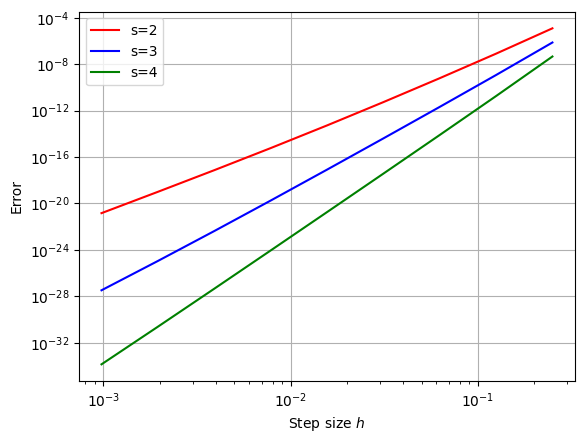

In [26]:
c = 1
def error_Taylor_truncation(h, s, c):
    r"""
    Computes the error of the Taylor truncation of the Magnus expansion of order 2s+1.
    h: step size
    s: order of the Magnus expansion
    c: norm of the Hamiltonian and its derivatives
    """
    
    return h**(2*s+1)*(
        (c**(2*s+1)/((2*s+1)*2**(2*s+2))) + c*h/4 - (h**(2*s+1)*c**(2*s+1))/(2**(2*s+1))
    )*(h/(1-h))*((h/2)/(1-(h/2)))

# Plot the error of the Taylor truncation for different values of s and h
hs = [1/(2) * 1/2**i for i in range(1,10)]

for (s, color) in zip([2, 3, 4], ['r', 'b', 'g']):
    plot_hs = []
    error = []
    for h in hs:
        plot_hs.append(h)
        error.append(error_Taylor_truncation(h, s, c)/h)

    plt.plot(plot_hs, error, color = color, label = f's={s}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel(r'Step size $h$')
plt.grid()

Error of the exponential of the Magnus operator 

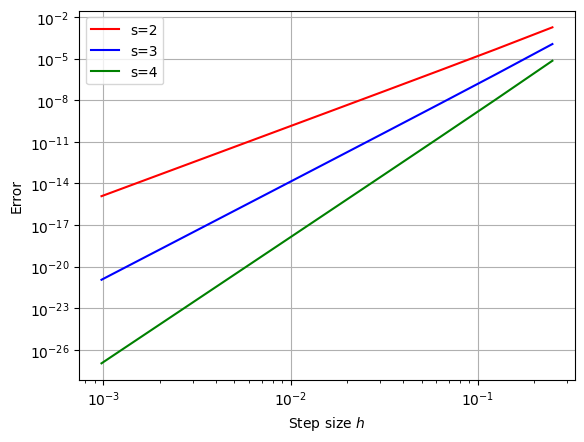

In [60]:
c = 1
def error_exp_Magnus_Taylor_truncation(h, s, c):
    r"""
    Computes the error of the Taylor truncation of the Magnus expansion of order 2s+1.
    h: step size
    s: order of the Magnus expansion
    c: norm of the Hamiltonian and its derivatives
    """
    
    return (np.e/2)*(h*c)**(2*s+2)/(1-h*c)

# Plot the error of the Taylor truncation for different values of s and h
hs = [1/(2) * 1/2**i for i in range(1,10)]

for (s, color) in zip([2, 3, 4], ['r', 'b', 'g']):
    plot_hs = []
    error = []
    for h in hs:
        plot_hs.append(h)
        error.append(error_exp_Magnus_Taylor_truncation(h, s, c)/h)

    plt.plot(plot_hs, error, color = color, label = f's={s}')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel(r'Step size $h$')
plt.grid()